In [1]:
# Religious Migration Analysis 1990-2020
# Author: Kristofer O'Garro
# Date: 11/21/2024
# Data Source: Pew Research Center (https://www.pewresearch.org/dataset/dataset-religious-composition-of-the-worlds-migrants-1990-2020/)

"""
This analysis explores global religious migration patterns from 1990-2020, 
examining how migration flows have influenced religious demographics across different 
geographical scales.

Dataset Structure:
- 26712 rows
- 9 columns
- Hierarchical data (Country -> Regional -> Global levels)
- Time period: 1990-2020 (5-year intervals)
"""

'\nThis analysis explores global religious migration patterns from 1990-2020, \nexamining how migration flows have influenced religious demographics across different \ngeographical scales.\n\nDataset Structure:\n- 26712 rows\n- 9 columns\n- Hierarchical data (Country -> Regional -> Global levels)\n- Time period: 1990-2020 (5-year intervals)\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [3]:
migration = pd.read_csv('data/Incoming_and_Outgoing_Migrant_Counts.csv', thousands=',')
migration.head(5)

,Direction,Year,Country,Religion,Count,Percent,Region,level,countrycode
0,Incoming,1990,Global Total,All,"152,970,000",100.0,Global,3,9999
1,Incoming,1990,Global Total,Buddhist,"4,590,000",3.0,Global,3,9999
2,Incoming,1990,Global Total,Christian,"72,710,000",47.5,Global,3,9999
3,Incoming,1990,Global Total,Hindu,"9,130,000",6.0,Global,3,9999
4,Incoming,1990,Global Total,Jew,"2,340,000",1.5,Global,3,9999


## Cleaning the data

In [5]:
# Initial data exploration
def explore_data_quality(df):
    """
    Perform initial data quality checks.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe to analyze
        
    Returns:
    --------
    dict
        Dictionary containing data quality metrics
    """
    quality_report = {
        'missing_values': df.isnull().sum(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
        'data_types': df.dtypes
    }
    return quality_report

In [6]:
explore_data_quality(migration)

{'missing_values': Direction      0
 Year           0
 Country        0
 Religion       0
 Count          0
 Percent        0
 Region         0
 level          0
 countrycode    0
 dtype: int64,
 'unique_values': {'Direction': 2,
  'Year': 7,
  'Country': 239,
  'Religion': 8,
  'Count': 834,
  'Percent': 955,
  'Region': 7,
  'level': 3,
  'countrycode': 239},
 'data_types': Direction       object
 Year             int64
 Country         object
 Religion        object
 Count           object
 Percent        float64
 Region          object
 level            int64
 countrycode      int64
 dtype: object}

In [7]:
#Changing the following column type to 'category' for memory optimization: Direction, Religion, Region, Level 
migration = migration.astype({
    'Direction': 'category',
    'Religion': 'category',
    'Region': 'category',
    'level': 'category',
})

migration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26712 entries, 0 to 26711
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Direction    26712 non-null  category
 1   Year         26712 non-null  int64   
 2   Country      26712 non-null  object  
 3   Religion     26712 non-null  category
 4   Count        26712 non-null  object  
 5   Percent      26712 non-null  float64 
 6   Region       26712 non-null  category
 7   level        26712 non-null  category
 8   countrycode  26712 non-null  int64   
dtypes: category(4), float64(1), int64(2), object(2)
memory usage: 1.1+ MB


In [8]:
#Standardized column names to lowercase
migration.columns = migration.columns.str.lower()

In [9]:
migration['count']

0        152,970,000
1          4,590,000
2         72,710,000
3          9,130,000
4          2,340,000
            ...     
26707       < 10,000
26708       < 10,000
26709         20,000
26710       < 10,000
26711         10,000
Name: count, Length: 26712, dtype: object

In [10]:
# Replacing values of '< 10,000' with 5,000 for numerical calculations. The number 5000 was chosen as a midpoint since we don't have the actual numbers
migration['count'] = migration['count'].replace('< 10,000', '5000')
migration['count']

0        152,970,000
1          4,590,000
2         72,710,000
3          9,130,000
4          2,340,000
            ...     
26707           5000
26708           5000
26709         20,000
26710           5000
26711         10,000
Name: count, Length: 26712, dtype: object

In [11]:
migration.dtypes

direction      category
year              int64
country          object
religion       category
count            object
percent         float64
region         category
level          category
countrycode       int64
dtype: object

In [12]:
migration['count'] = migration['count'].str.replace(',', '')
migration['count'] = pd.to_numeric(migration['count'])

In [13]:
migration.dtypes

direction      category
year              int64
country          object
religion       category
count             int64
percent         float64
region         category
level          category
countrycode       int64
dtype: object

## Global Analysis

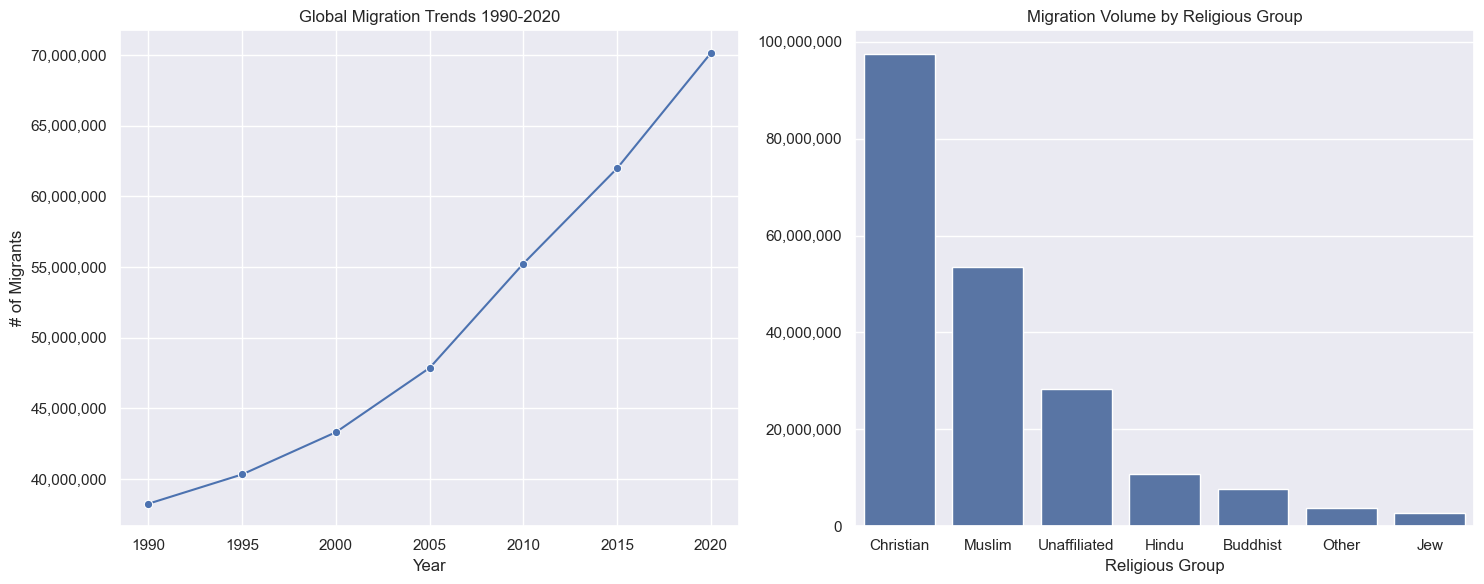

In [15]:
#Filtering for Global data
global_level_df = migration[migration['level'] == 3].copy()
global_level_df['religion'] = global_level_df['religion'].cat.remove_categories(['All'])
order = global_level_df.groupby('religion', observed=True)['count'].mean().sort_values(ascending=False).index

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=global_level_df, 
             x='year', y='count', errorbar=None, marker='o', ax=ax1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_ylabel('# of Migrants')
ax1.set_xlabel('Year')
ax1.set_title('Global Migration Trends 1990-2020')

sns.barplot(data = global_level_df, 
            x='religion', y='count', errorbar=None, order=order, ax=ax2)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('')
ax2.set_xlabel('Religious Group')
ax2.set_title('Migration Volume by Religious Group')

plt.tight_layout()

#### Global migration volume has consistently increased since 1990 with the sharpest increase occurring after 2005. Of these migrants, Christians make up the largest group, followed by Muslims and the religiously unaffiliated

Text(0, 0.5, 'Number of Migrants')

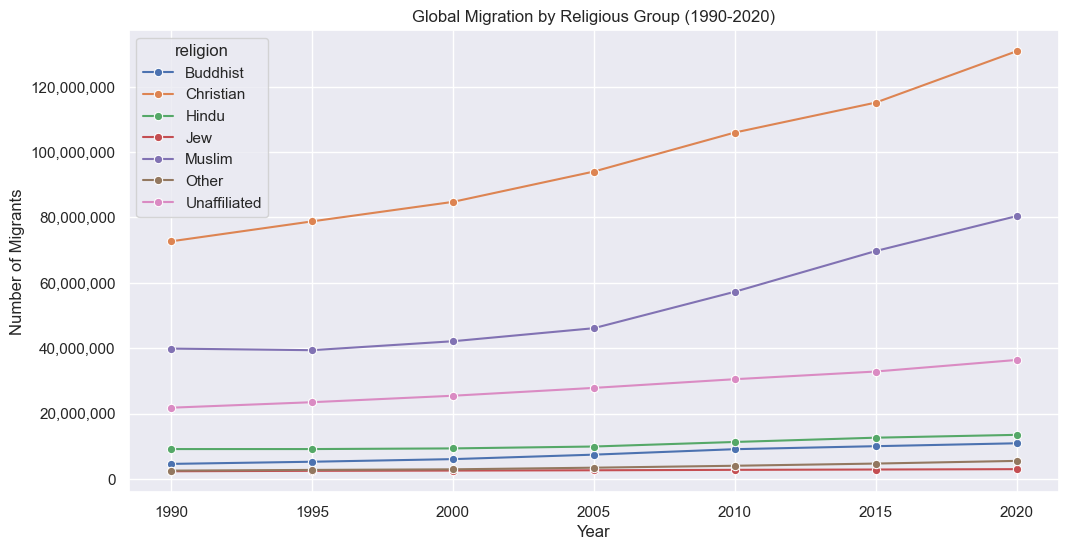

In [17]:
# Create a line plot showing migration trends by religion
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_level_df[global_level_df != 'All'], 
             x='year', y='count', hue='religion', errorbar=None, marker='o')

# Format y-axis to show actual numbers with commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Global Migration by Religious Group (1990-2020)')
plt.xlabel('Year')
plt.ylabel('Number of Migrants')

### Global Growth Rates

In [43]:
global_level_df

,direction,year,country,religion,count,percent,region,level,countrycode
0,Incoming,1990,Global Total,NaN,152970000,100.0,Global,3,9999
1,Incoming,1990,Global Total,Buddhist,4590000,3.0,Global,3,9999
2,Incoming,1990,Global Total,Christian,72710000,47.5,Global,3,9999
3,Incoming,1990,Global Total,Hindu,9130000,6.0,Global,3,9999
4,Incoming,1990,Global Total,Jew,2340000,1.5,Global,3,9999
...,...,...,...,...,...,...,...,...,...
24803,Outgoing,2020,Global Total,Hindu,13480000,4.8,Global,3,9999
24804,Outgoing,2020,Global Total,Jew,2980000,1.1,Global,3,9999
24805,Outgoing,2020,Global Total,Muslim,80420000,28.7,Global,3,9999
24806,Outgoing,2020,Global Total,Other,5510000,2.0,Global,3,9999


In [66]:
global_growth_df = global_level_df.pivot_table(index='religion', columns='year', values='count').reset_index()
global_growth_df

year,religion,1990,1995,2000,2005,2010,2015,2020
0,Buddhist,4590000.0,5250000.0,6050000.0,7420000.0,9090000.0,10010000.0,10900000.0
1,Christian,72710000.0,78810000.0,84780000.0,94060000.0,106000000.0,115160000.0,130880000.0
2,Hindu,9130000.0,9130000.0,9330000.0,9910000.0,11300000.0,12610000.0,13480000.0
3,Jew,2340000.0,2470000.0,2550000.0,2640000.0,2770000.0,2870000.0,2980000.0
4,Muslim,39880000.0,39390000.0,42130000.0,46120000.0,57270000.0,69730000.0,80420000.0
5,Other,2530000.0,2750000.0,2930000.0,3430000.0,4020000.0,4690000.0,5510000.0
6,Unaffiliated,21790000.0,23470000.0,25450000.0,27850000.0,30510000.0,32860000.0,36400000.0
